In [1]:
import os
import sys

import numpy as np
from scipy import linalg
from matplotlib import style
import matplotlib.pyplot as plt
style.use('seaborn-darkgrid')

sys.path.append('../')
from alg_tools_1d import dirac_recon_time, periodicSinc, distance

In [2]:
'''utility functions used for plotting'''
def plot_dirac(tk, ak, color='red', marker='*', ax=None, label=''):
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    markerline211_1, stemlines211_1, baseline211_1 = \
        ax.stem(tk, ak, label=label, use_line_collection=True)
    plt.setp(stemlines211_1, linewidth=1.5, color=color)
    plt.setp(markerline211_1, marker=marker, linewidth=1.5, markersize=8,
             markerfacecolor=color, mec=color)
    plt.setp(baseline211_1, linewidth=0)
    plt.xlabel('t')
    plt.ylabel('amplitude')
    plt.xlim([0, TAU])
#     plt.axhline(0, color='k')
    
def plot_diracs(ax1, tk, ak, tk_recon, ak_recon, title):
    c1 = [0, 0.447, 0.741]
    m1 ='^'
    plot_dirac(tk, ak, c1, m1, ax=ax1, label='Original Diracs')
    
    c2 = [0.850, 0.325, 0.098]
    m2 = '*'
    plot_dirac(tk_recon, ak_recon, c2, m2, ax=ax1, label='Estimated Diracs')

    plt.axhline(0, color='k')
    plt.ylim([1.17 * np.min(np.concatenate((ak, ak_recon, np.array(0)[np.newaxis]))),
              1.17 * np.max(np.concatenate((ak, ak_recon, np.array(0)[np.newaxis])))])
    plt.ylabel('amplitudes', fontsize=12)
    ax1.yaxis.set_label_coords(-0.095, 0.5)
    plt.legend(numpoints=1, loc=0, fontsize=9, framealpha=0.3,
               handletextpad=.2, columnspacing=0.6, labelspacing=0.05, ncol=2)
    plt.title(title, fontsize=12)

# Overview 

This notebook explains how to reconstruct a signal consisting of a $\tau$-periodic stream of Diracs at unknown locations. We will apply the following standard FRI-based workflow. 

## 1. Generate signal

We generate the FRI signal which we will then try reconstruct:

<br><center>
$ \displaystyle x = \sum_{k' \in \mathbb{Z}} \sum_{k=1}^{K}  \alpha_k \delta(t - t_k - k' \tau ) $ (1) 
</center>

*CODE: Inspect the signal and make sure you understand its parameters.*


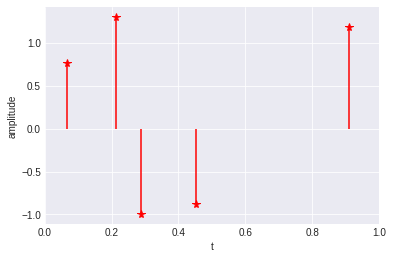

In [3]:
np.random.seed(7)

K = 5  # number of Diracs
TAU = 1  # period of the Dirac stream

# amplitudes of the Diracs
ak = np.sign(np.random.randn(K)) * (1 + (np.random.rand(K) - 0.5) / 1.)

# locations of the Diracs
tk = np.random.rand(K) * TAU

# plot the signal.
plot_dirac(tk, ak)

## 2. Simulate measurements

We also simulate measurements by constructing a non-uniformly sampled, low-pass filtered signal, and add measurement noise
$$y_{\ell} = \sum_{k=1}^K \alpha_k \varphi(t_{\ell}' - t_k),$$
for $\ell=1,\cdots,L$. Here $\varphi(t)=\frac{\sin(\pi B t)}{B\tau\sin(\pi t / \tau)}$ and $B$ is the bandwidth of the ideal lowpass filter.

*CODE: Do you understand the values of $M$, $B$ and $L$ in the code snippet below?*

*CODE: Generate the signal $y_\ell$ and add noise.*

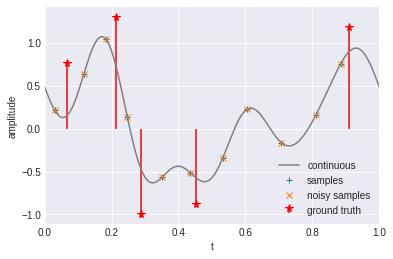

In [4]:
np.random.seed(3)

def generate_noisy_signal(signal, SNR=None, sigma_noise=None): 
    ''' Add noise to given signal. 
    
    If SNR is given: generate signal such that resulting SNR equals SNR.
    If sigma_noise is given: add Gaussian noise of standard deviation sigma_noise.
    
    :param SNR: desired SNR (in dB). 
    :param sigma_noise: desired standard deviation. 
    
    :return: noisy signal, noise vector
    
    '''
    if SNR is not None: 
        noise = np.random.randn(len(signal))
        noise = noise / linalg.norm(noise) * linalg.norm(signal) * 10 ** (-SNR / 20.)
    elif sigma_noise is not None:
        noise = np.random.normal(scale=sigma_noise, loc=0, size=signal.shape)
    return signal + noise, noise

def generate_time_samples(tau, L):
    ''' Generate L randomly distributed time instances. '''
    # number of time domain samples
    Tmax = tau / L  # the average sampling step size (had we used a uniform sampling setup)

    # generate the random sampling time instances
    t_samp = np.arange(0, L, dtype=float) * Tmax
    t_samp += np.sign(np.random.randn(L)) * np.random.rand(L) * Tmax / 2.
    # round t_samp to [0, tau)
    t_samp -= np.floor(t_samp / tau) * tau
    return t_samp

def phi(t):
    ''' Dirichlet kernel evaluated at t. '''
    numerator = np.sin(np.pi * B * t)
    denominator = B * TAU * np.sin(np.pi * t / TAU)
    
    idx = np.abs(denominator) < 1e-12
    
    numerator[idx] = np.cos(np.pi * B * t[idx])
    denominator[idx] = np.cos(np.pi * t[idx] / TAU)
    return numerator / denominator

M = K # number of Fourier samples (at least K)
B = (2. * M + 1.) / TAU  # bandwidth of the sampling filter
L = (2 * M + 1) # number of time samples

# measured signal
t_samp = generate_time_samples(TAU, L)

#################### CALCULATE SAMPLES y_l #####################

## sampled version
tl_grid, tk_grid = np.meshgrid(tk, t_samp)
y_ell_samp = ak.T @ phi(tl_grid - tk_grid).T


## continuous version
t_continuous = np.linspace(0, TAU, 10000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
y_ell_continuous = ak.T @ phi(tl_grid - tk_grid).T

## generate noisy signal
# SNR level
P = np.inf  # i.e., noiseless
# P = 10  # SNR = 10dB

y_ell, noise = generate_noisy_signal(y_ell_samp, SNR=P)

# plot the signal
plt.figure()
plt.plot(t_continuous, y_ell_continuous, color='grey', label='continuous')
plt.plot(t_samp, y_ell_samp, linestyle='', marker='+', label='samples')
plt.plot(t_samp, y_ell, linestyle='', marker='x', label='noisy samples')
plot_dirac(tk, ak, label='ground truth', ax=plt.gca())
plt.xlabel('t')
plt.legend()
plt.show()

## 3. Find standard form

Since the signal it is FRI, we know that we can find a signal of the standard form with a 1-to-1 relation to the original signal:

<center>
$ \displaystyle\hat{x}_m = \sum_{k=1}^{K} \beta_k u_k^m $ (2) 
</center>

*PEN AND PAPER: Find values of $\beta_k$ and $u_k$*. 

*CODE: Implement standard form below*. 

<br> 
Since the above holds, we know that the signal can be anihilated by a filter $h$. 

*OPTIONAL: Show that for this simple example, this filter is given by*

$$ H(z) = h_0 \prod_{k=1}^K (1 - u_k z^{-1}) $$

In [5]:
def get_standard_form(ak, tk):
    ''' 
    :param ak: vector of Dirac amplitudes
    :param tk: vector of Dirac locations

    :return: vector of standard form coefficients
    '''
    ms = np.arange(-np.floor(B * TAU / 2.), 1 + np.floor(B * TAU / 2.))
    tk_grid, m_grid_gt = np.meshgrid(tk, ms)
    
    x_hat = 1. / TAU * np.exp(-2j * np.pi / TAU * m_grid_gt * tk_grid) @ ak
    return x_hat

x_hat = get_standard_form(ak, tk)

## 4. Find and implement $ G $ 

Once the signal is in form of Eq-(2), we need to identify how it is related to measurements $y$. 

*PEN AND PAPER: find the expression of matrix $G$ such that $ G \hat{x} = y$*

*CODE: implement G below.*

In [6]:
def get_G(t_samp):
    '''
    Compute G such that y=Gx
    
    :param t_samp: vector of sampling times.
    :return: matrix G 
    '''
    m_grid, t_samp_grid = np.meshgrid(np.arange(-np.floor(B * TAU / 2.), 1 + np.floor(B * TAU / 2.)), t_samp)
    G = 1. / B * np.exp(2j * np.pi / TAU * m_grid * t_samp_grid)
    return G

G = get_G(t_samp)

## generate noiseless signal
y_ell_test = np.real(np.dot(G, x_hat))

assert np.isclose(y_ell_samp, y_ell_test).all()

## 5. Solve optimization

Now we have all the ingredients to solve the optimization of the form: 

<center>
find $ \hat{x}, h $ 
</center>

<center>
such that $ || y - G \hat{x} ||_2 \leq \varepsilon $
</center>

<center>
and $ \hat{x} * h = 0 $
</center>

*CODE: you do not have to implement this part, just inspect the obtained solution and make sure it is correct.*

In [7]:
# noise energy, in the noiseless case 1e-10 is considered as 0
noise_level = np.max([1e-10, linalg.norm(noise)])
max_ini = 100  # maximum number of random initialisations
xhat_recon, min_error, c_opt, ini = dirac_recon_time(G, y_ell, K, noise_level, max_ini)

#################### VERIFY IF xhat_recon IS CORRECT #####################
assert np.allclose(xhat_recon, x_hat)

print('Noise level: {:.2e}'.format(noise_level))
print('Minimum approximation error |a - Gb|_2: {:.2e}'.format(min_error))

Noise level: 1.00e-10
Minimum approximation error |a - Gb|_2: 2.80e-15


## 6. Reconstruct original signal

Now that we have extracted the filter and $\hat{x}$, what would you do to find the signal's parameters ?

In [8]:
def get_locations(c_opt):
    '''
    Get dirac locations from filter coefficients.  
    
    :param c_opt: vector of annihilating filter coefficients
    
    :return: vector of dirac locations (between 0 and TAU)
    '''

    ############### GET tk_recon FROM RECONSTRUCTED FILTER ##################
    z = np.roots(c_opt)
    z = z / np.abs(z)
    tk_recon = np.real(TAU * 1j / (2 * np.pi) * np.log(z))
    tk_recon = np.sort(tk_recon - np.floor(tk_recon / TAU) * TAU)
    return tk_recon

tk_recon = get_locations(c_opt)

# location estimation error
t_error = distance(tk_recon, tk)[0]
print('location error: {:.2e}'.format(t_error))

location error: 1.05e-15


In [9]:
def get_amplitudes(tk_recon, t_samp, y_ell):
    '''
    Get dirac amplitudes. 
    
    :tk_recon: vector of dirac locations.
    :t_samp: vector of sampling times
    :y_ell: vector of measurements
    
    :return: vector of amplitudes of diracs. 
    '''
    tl_grid, tk_grid = np.meshgrid(tk_recon, t_samp)
    Phi_recon = phi(tl_grid - tk_grid)
    ak_recon = np.real(linalg.lstsq(Phi_recon, y_ell)[0])
    
    return ak_recon

ak_recon = get_amplitudes(tk_recon, t_samp, y_ell)

a_error = distance(ak_recon, ak)[0]
print('amplitude error: {:.2e}'.format(a_error))

amplitude error: 1.95e-14


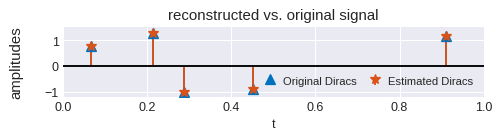

In [10]:
fig = plt.figure(num=1, figsize=(5.5, 2.5), dpi=90)
ax1 = plt.axes([0.125, 0.59, 0.85, 0.31])

t_error_pow = np.int(np.floor(np.log10(t_error)))
title = 'reconstructed vs. original signal'
plot_diracs(ax1, tk, ak, tk_recon, ak_recon, title)